In [1]:
# !pip install -r requirements.txt

# Example - Power consumption estimation

This notebook withholds a (minimal) data science pipeline, where we go from RAW data to prediction (with a confidence interval).

We primarily focus on the use of two _open-source_ components build by `PreDiCT-IDLab`:
- [tsflex](https://predict-idlab.github.io/tsflex/): toolkit for flexible time-series feature extraction
- [plotly-resampler](https://predict-idlab.github.io/plotly-resampler/): interactive visualization of large sequences of data

In [2]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

# the holy trinity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import math
import pickle

import urllib.request as urllib2
from io import BytesIO
from zipfile import ZipFile

import catboost
import shap

from functional import seq
from IPython.display import display

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler
from plotly_resampler.downsamplers import LTTB, EveryNthPoint

pd.set_option("display.max_columns", None)
plt.style.use('ggplot')


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`


In [115]:
LOADED_RAW_DATA = True
CALCULATED_FEATURES = False

## Helper functions

In [3]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import learning_curve

In [4]:
def print_regression_metrics(y_true, y_pred, msg):
    print(f"MSE  [{msg}]: ", round(mean_squared_error(y_true, y_pred), 3))
    print(f"MAE  [{msg}]: ", round(mean_absolute_error(y_true, y_pred), 3))
    print(f"MAPE [{msg}]: ", round(mean_absolute_percentage_error(y_true, y_pred), 3))
    print(f"R2   [{msg}]: ", round(r2_score(y_true, y_pred), 3))


def scatter_features(
    X: pd.DataFrame,
    y: np.ndarray,
    output_name=None,
    n_cols=5,
    scatter_alpha=0.4,
    save_path: str = None,
):
    """Scatter plots of the features in terms of the output.

    :param X: the (input) features as a pd.DataFrame.
    :param y: the output values.
    :param output_name: the name the output (y), will be used as ylabel for the plots.
    :param n_cols: the number of subplot columns.
    :param scatter_alpha: the opacity of the scattered data for all the subplots.
    :param save_path: the path where the scatter plot should be saved.

    """
    n_rows = math.ceil(len(X.columns) / n_cols)
    plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

    for idx, col in enumerate(X.columns):
        plt.subplot(n_rows, n_cols, idx + 1)
        try:
            plt.scatter(X[col], y, alpha=scatter_alpha)
        except Exception:
            print(f"Could not plot {col}!")
        plt.xlabel(col)
        if output_name and idx % n_cols == 0:
            plt.ylabel(output_name)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Scatter plot saved at {save_path}!")
    else:
        return plt.show()


def plot_learning_curve(
    estimator,
    title: str,
    X,
    y,
    ylim=None,
    cv: int = None,
    n_jobs: int = None,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring=None,
):
    """Generate a simple plot of the test and training learning curve.

    borrowed from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.
    title : string
        Title for the chart.
    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.
    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.
    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.
        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.
        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.
    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.
    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    scoring : str or callable, optional (default=None)
        Scoring method for the model.
        see: https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
    """
    plt.figure(figsize=(20, 10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(True)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")
    return plt.show()

# 1. loading in the data

This example uses the pulbic UCI [power consumption](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) dataset.

This dataset withholds measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

In [5]:
zip_url: str = "https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip"
zipped_file_name: str = "household_power_consumption.txt"

if not LOADED_RAW_DATA:
    df_power_consumption: pd.DataFrame = pd.read_csv(
        ZipFile(BytesIO(urllib2.urlopen(zip_url).read())).open(zipped_file_name),
        sep=";",
        parse_dates={"timestamp": ["Date", "Time"]},
        infer_datetime_format=True,
        low_memory=False,
        na_values=["nan", "?"],
        index_col="timestamp",
        dtype="float32",
    )
    df_power_consumption.to_parquet("df_power_consumption.parquet")
else:
    df_power_consumption = pd.read_parquet("df_power_consumption.parquet")

display(df_power_consumption.sample(3))
print("-" * 80)
df_power_consumption.info()

Global_active_power  Global_reactive_power     Voltage  \
timestamp                                                                     
2009-10-03 18:31:00                3.670                  0.162  235.119995   
2007-03-24 17:23:00                2.728                  0.000  239.779999   
2009-04-21 08:37:00                0.352                  0.112  239.429993   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
timestamp                                                               
2009-10-03 18:31:00              15.6            37.0             0.0   
2007-03-24 17:23:00              11.4             0.0             5.0   
2009-04-21 08:37:00               1.6             0.0             0.0   

                     Sub_metering_3  
timestamp                            
2009-10-03 18:31:00            17.0  
2007-03-24 17:23:00            18.0  
2009-04-21 08:37:00             1.0

--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float32
 1   Global_reactive_power  float32
 2   Voltage                float32
 3   Global_intensity       float32
 4   Sub_metering_1         float32
 5   Sub_metering_2         float32
 6   Sub_metering_3         float32
dtypes: float32(7)
memory usage: 71.2 MB


# 2. Exploratory Data Analysis (EDA)

**first step**: Reading the [dataset description](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption) (and gather all information about the dataset)

## 2.1 Summary of the data-properties


**global variables**:
* `global_active_power`: household global **minute averaged** active power (kilowatt)
* `global_reactive_power`: household global **minute averaged** reactive power (kilowatt)
* `global_intensity`: household global **minute averaged** current (ampere)
* `voltage`: minute-averaged voltage (volt)

**sub meterings**:
* `sub_metering_1`: **kitchen** - dishwasher & microwave - (in watt-hour of **active energy**)
* `sub_metering_2`: **laundry room** - washing maching, tumble drier, refrigerator & light (in watt-hour of **active energy**)
* `sub_metering_3`: electric **water-heater & air conditioner** (in watt-hour of **active energy**)


Note: users are only billed for **active power**, so this is an interesting variable.

> <p style="color: dodgerblue"><b>Q</b>: Which EDA steps would you perform to obtain more insights in the data?</p>

## 2.2 `Pandas` data checks

In [9]:
print(f"rows={df_power_consumption.shape[0]:,}\tcols={df_power_consumption.shape[1]:,}")
print("-" * 100)
display(df_power_consumption.head(3))
print("-" * 100)
display(df_power_consumption.tail(3))

rows=2,075,259	cols=7
----------------------------------------------------------------------------------------------------


Global_active_power  Global_reactive_power     Voltage  \
timestamp                                                                     
2006-12-16 17:24:00                4.216                  0.418  234.839996   
2006-12-16 17:25:00                5.360                  0.436  233.630005   
2006-12-16 17:26:00                5.374                  0.498  233.289993   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
timestamp                                                               
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   

                     Sub_metering_3  
timestamp                            
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0

----------------------------------------------------------------------------------------------------


Global_active_power  Global_reactive_power     Voltage  \
timestamp                                                                     
2010-11-26 21:00:00                0.938                    0.0  239.820007   
2010-11-26 21:01:00                0.934                    0.0  239.699997   
2010-11-26 21:02:00                0.932                    0.0  239.550003   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
timestamp                                                               
2010-11-26 21:00:00               3.8             0.0             0.0   
2010-11-26 21:01:00               3.8             0.0             0.0   
2010-11-26 21:02:00               3.8             0.0             0.0   

                     Sub_metering_3  
timestamp                            
2010-11-26 21:00:00             0.0  
2010-11-26 21:01:00             0.0  
2010-11-26 21:02:00             0.0

In [10]:
df_power_consumption.index[-1] - df_power_consumption.index[0]

Timedelta('1441 days 03:38:00')

In [11]:
# so the data is actually regularly sampled
df_power_consumption.index.to_series().diff().value_counts()

0 days 00:01:00    2075258
Name: timestamp, dtype: int64

The data spans ~4 years; and is **regularly sampled**; Each minute, there is a new observation for each property

In [12]:
# It appears we have some NaN's (not a numbers) in the data.
print("NaN sum:")
df_power_consumption.isna().sum()

NaN sum:


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [13]:
df_power_consumption.isna().sum(axis=1).value_counts()

0    2049280
7      25979
dtype: int64

The check above confirms that the `NaN` for each property occurs at the same time -> fair to assume their just is no data

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level func

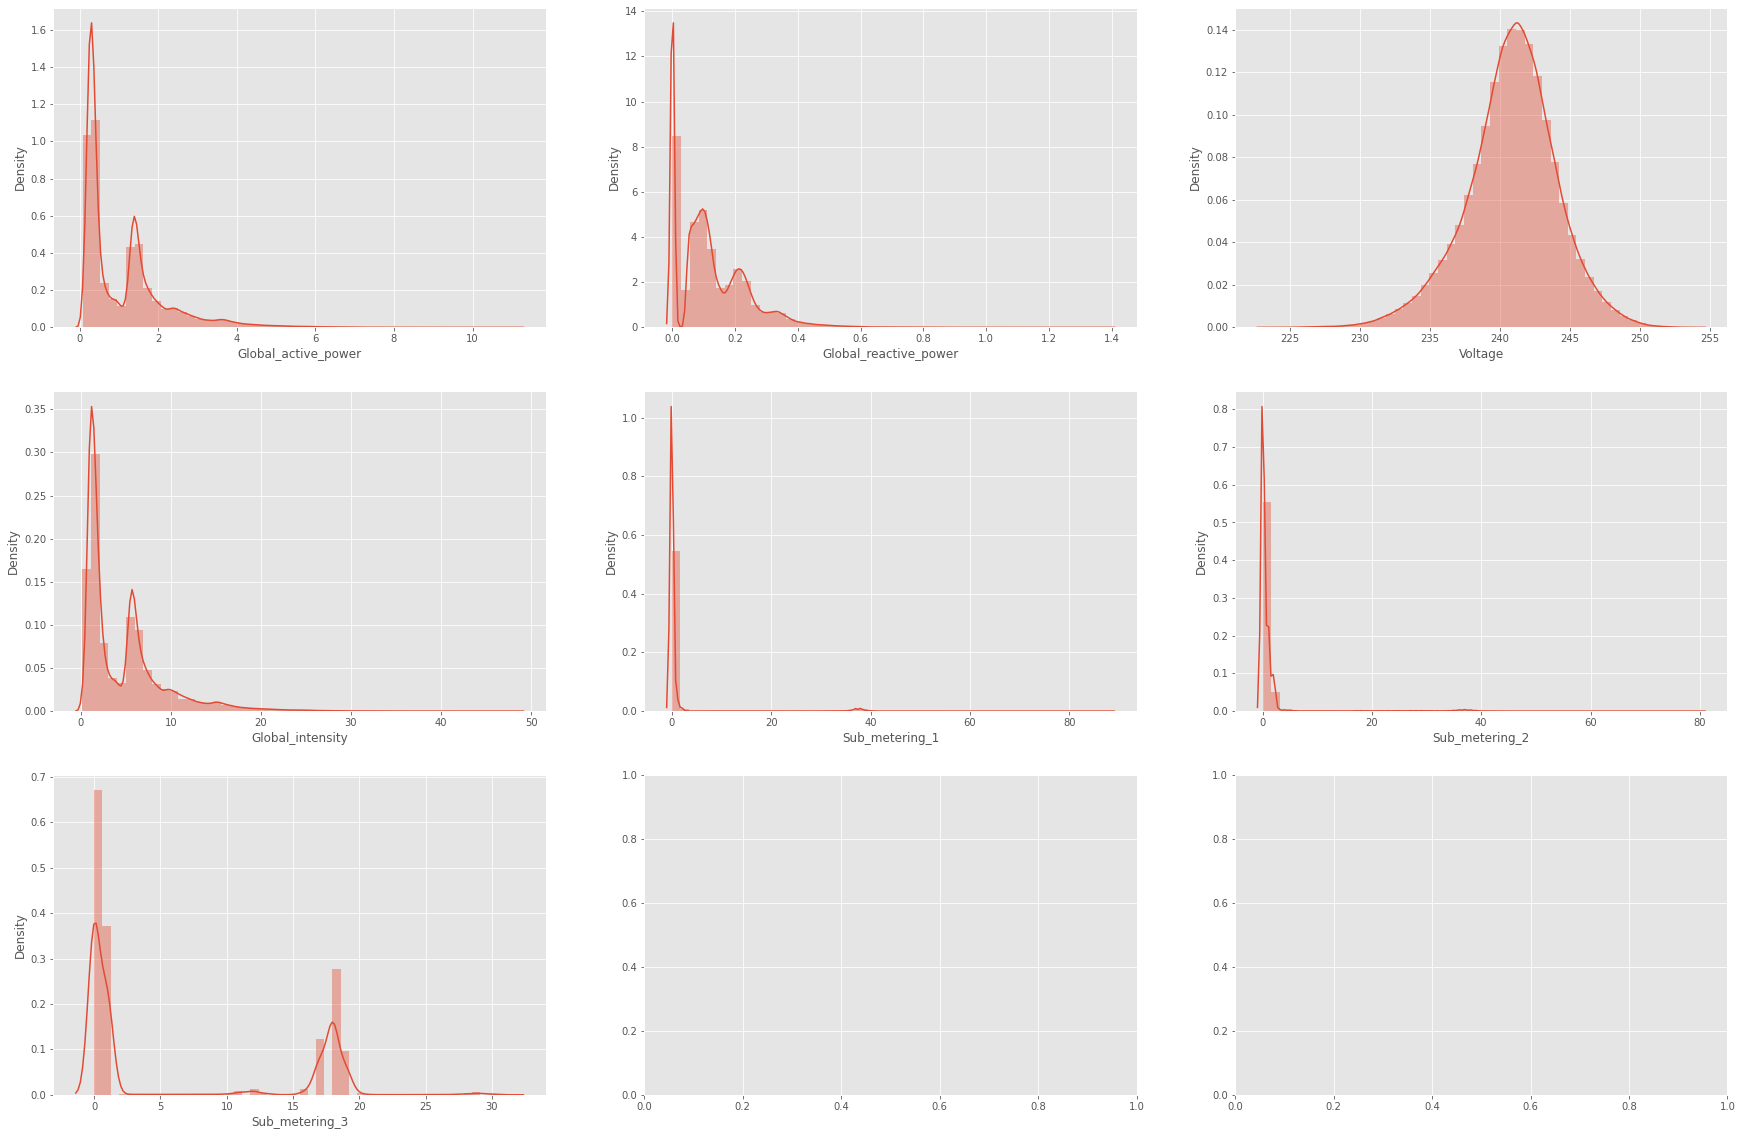

In [37]:
n_rows = 3
n_cols = math.ceil(df_power_consumption.shape[1] / n_rows)
fig, axs = plt.subplots(nrows=3, ncols=n_cols, figsize=(30, 20))
# create distplots
for i, column in enumerate(df_power_consumption.columns):
    sns.distplot(df_power_consumption[column], ax=axs[i // n_rows, i % n_rows], )

## 2.3 Processing based on data checks

In [6]:
# FROM now on -> we drop the nan's
df_power_consumption = df_power_consumption.dropna(how="all", axis=0)

In [7]:
df_power_consumption.index.to_series().diff().value_counts()

0 days 00:01:00    2049208
0 days 00:02:00         38
0 days 00:03:00         14
0 days 00:04:00          2
0 days 00:39:00          1
5 days 00:27:00          1
1 days 09:48:00          1
2 days 04:10:00          1
0 days 14:52:00          1
0 days 00:05:00          1
2 days 07:06:00          1
0 days 00:25:00          1
0 days 00:07:00          1
0 days 01:11:00          1
0 days 00:44:00          1
0 days 00:22:00          1
0 days 00:48:00          1
0 days 01:24:00          1
0 days 00:34:00          1
2 days 14:04:00          1
3 days 15:18:00          1
Name: timestamp, dtype: int64

> <p style="color: dodgerblue"><b>Q</b>: Which statistics would you look at?</p>

## 2.4 Statistics

In [38]:
df_power_consumption.describe().round(2).astype("str")

Global_active_power Global_reactive_power    Voltage Global_intensity  \
count           2049280.0             2049280.0  2049280.0        2049280.0   
mean                 1.09                  0.12     240.84             4.63   
std                  1.06                  0.11       3.24             4.44   
min                  0.08                   0.0      223.2              0.2   
25%                  0.31                  0.05     238.99              1.4   
50%                   0.6                   0.1     241.01              2.6   
75%                  1.53                  0.19     242.89              6.4   
max                 11.12                  1.39     254.15             48.4   

      Sub_metering_1 Sub_metering_2 Sub_metering_3  
count      2049280.0      2049280.0      2049280.0  
mean            1.12            1.3           6.46  
std             6.15           5.82           8.44  
min              0.0            0.0            0.0  
25%              0.0            0.0            0.0  
50%              0.0            0.0            1.0  
75%              0.0            1.0           17.0  
max             88.0           80.0           31.0

In [39]:
corr = df_power_consumption.corr() * np.tril(
    np.ones(tuple([len(df_power_consumption.columns)] * 2)), k=-1
)
pd.set_option("precision", 3)
corr.style.background_gradient(cmap="coolwarm", axis=None)

Some basic checks:

In [40]:
import scipy.stats as ss

power_estimation = df_power_consumption.Global_intensity * df_power_consumption.Voltage

print(
    "GAP - intensity corr:        ",
    ss.pearsonr(
        df_power_consumption.Global_active_power, df_power_consumption.Global_intensity
    ),
)
print(
    "GAP - power-estimation corr: ",
    ss.pearsonr(df_power_consumption.Global_active_power, power_estimation),
)

GAP - intensity corr:         (0.9988886002045057, 0.0)
GAP - power-estimation corr:  (0.9990928075842106, 0.0)


## 2.5 Raw data visualization using `plotly-resampler`

By using plotly-resampler, we are able to visualize the whole span of 4 years

In [41]:
fig = FigureResampler(
    make_subplots(
        rows=3,
        cols=1,
        shared_xaxes=True,
        specs=[[{"secondary_y": True}], [{}], [{"secondary_y": True}]],
        subplot_titles=["Globals", "Voltage", "Sub metering"],
    ),
    default_n_shown_samples=1000,
    default_downsampler=LTTB(interleave_gaps=True),
)

for c, row, visible, secondary_y in [
    ("Global_active_power", 1, 1, 0),
    ("Global_intensity", 1, "legendonly", 1),
    ("Global_reactive_power", 1, "legendonly", 0),
    ("Voltage", 2, 1, 0),
    ("Sub_metering_1", 3, 1, 0),
    ("Sub_metering_2", 3, 1, 0),
    ("Sub_metering_3", 3, 1, 0),
]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        secondary_y=secondary_y,
        row=row,
        col=1,
    )


# add a shaded weekend region on the lowest row
datelist = pd.date_range(
    df_power_consumption.index[0].date(), df_power_consumption.index[-1], freq="D"
)
weekend = datelist.weekday.isin([5, 6]).astype(int)
fig.add_trace(
    go.Scattergl(
        line_shape="hv",
        name="Weekend",
        line_color="rgba(0,0,0,0)",
        fillcolor="rgba(99, 110, 250, 0.15)",
        fill="tozeroy",
    ),
    hf_x=datelist,
    hf_y=weekend,
    limit_to_view=True,
    max_n_samples=len(weekend),
    secondary_y=True,
    row=3,
    col=1,
)


fig.update_layout(height=800)
fig.show_dash(mode="external", port=8050)

Dash app running on http://127.0.0.1:8050/


> <p style="color: dodgerblue"><b>Q</b>: What catches your eye?</p>

# 3. Define the objective

The objective is:
> **forecast** the **average** `Global active power` (GAP)


After a requirement meeting with the client:

> He/she wants to know:
* the **average** power-consumption for **15 minutes**, and 
* this XX minutes in advance for the next 15-minutes period.

In [80]:
# Our client wants to know the average power consumption per 15 minutes and this
# XX minutes in advance for the next 15-minute period
avg_window_min = 15
shift_min = -(5 + avg_window_min)

avg_col = f"GAP_avg{avg_window_min}min"
target_col = f"{avg_col}_shift{shift_min}min"

# create the target by (1) calculating the average and (2) shifting the data so we will forecast
df_power_consumption[avg_col] = df_power_consumption.rolling(
    avg_window_min, center=True
)["Global_active_power"].aggregate(np.nanmean)
df_power_consumption[target_col] = df_power_consumption[avg_col].shift(shift_min)

 ### 🚨 Perform visual inspection 🔍

> <p style="color: dodgerblue"><b>Q</b>: Is the target correct?</p>

In [81]:
fig = FigureResampler(
    make_subplots(rows=1, cols=1, shared_xaxes=True),
    default_downsampler=LTTB(interleave_gaps=True),
)

for c, row, visible in [
    ("Global_active_power", 1, 1),
    (target_col, 1, "legendonly"),
    (avg_col, 1, "legendonly"),
]:
    fig.add_trace(
        go.Scattergl(name=c, visible=visible),
        hf_x=df_power_consumption.index,
        hf_y=df_power_consumption[c],
        row=row,
        col=1,
    )

fig.update_layout(height=400)
fig.show_dash(mode="external", port=8050)

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



Dash app running on http://127.0.0.1:8050/


# 4. Machine learning

> <p style="color: dodgerblue"><b>Q</b>: How would you apply train-test split?</p>

## 4.1 Train-test split

In [82]:
time_col = "time"
train_columns = [f"Sub_metering_{i}" for i in range(1, 4)] + [
    time_col,
    "Global_active_power",
    "Global_reactive_power",
]
target_col = target_col

# The percentage of data used for testing
test_pct = 0.2
day_margin = 3

# add the timestamp col
df_power_consumption[time_col] = df_power_consumption.index

# Temporal split: Use the last test_pct of the data as test_data
df_train = df_power_consumption[: -int(len(df_power_consumption) * test_pct)].copy()
X_train, y_train = df_train[train_columns], df_train[target_col]

df_test = df_power_consumption[df_train.index[-1] + pd.Timedelta(days=day_margin):]
X_test, y_test = df_test[train_columns], df_test[target_col]

X_test.to_parquet("X_test.parquet")
y_test.to_frame().to_parquet("y_test.parquet")

> <p style="color: dodgerblue"><b>Q</b>: Which features seem interesting to extract?</p>

## 4.2 Feature extraction

In [83]:
import holidays
import scipy.stats as ss
from tsflex.chunking import chunk_data
from tsflex.features import FeatureCollection, MultipleFeatureDescriptors
from tsflex.features.utils import make_robust

In [84]:
# some feature functions
def slope(x):
    return (x[-1] - x[0]) / x[0] if x[0] else 0


def abs_diff_mean(x):
    return np.mean(np.abs(x[1:] - x[:-1])) if len(x) > 1 else 0


def diff_std(x):
    return np.std(x[1:] - x[:-1]) if len(x) > 1 else 0


# time based features
def time_float(x) -> float:
    x_ = pd.Timestamp(x[-1])
    return np.float32(x_.hour + x_.minute / 60)


def day_of_week(x) -> int:
    return pd.Timestamp(x[-1]).day_of_week


def is_holiday(x) -> bool:
    return pd.Timestamp(x[-1]) in holidays.France()


def yesterday_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) - pd.Timedelta(days=1)) in holidays.France()


def tomorrow_holiday(x) -> bool:
    return (pd.Timestamp(x[-1]) + pd.Timedelta(days=1)) in holidays.France()


funcs = [
    make_robust(f)
    for f in [np.min, np.max, np.std, np.mean, slope, ss.skew, abs_diff_mean, diff_std, sum]
]
time_funcs = [
    make_robust(f)
    for f in [time_float, day_of_week, is_holiday, yesterday_holiday, tomorrow_holiday]
]

# Create the feature collection
fc = FeatureCollection(
    feature_descriptors=[
        MultipleFeatureDescriptors(
            functions=funcs,
            series_names=list(set(train_columns).difference({time_col})),
            windows=["15min", "30min", "1h", "6h", "1d"],
            strides="15min",
        ),
        MultipleFeatureDescriptors(
            functions=time_funcs,
            series_names=time_col,
            windows=["15min"],
            strides="15min",
        ),
    ]
)

In [85]:
# fc

### Chunking train data

As shown in the visualizations, there were gaps in the train-data, by calling <br>
`tsflex.chunk_data`, we:
* omit these gaps
* chunk the data in duration-based chunks

In [86]:
# %%time
# chunk the data in blocks of `max_chunk_dur`
# also omits the gaps :)
chunks = chunk_data(
    data=df_train,
    max_chunk_dur="365 days",
    chunk_range_margin="10 min",
    sub_chunk_overlap="15min",
)

we will now use these yearly chunks to extract the features

In [87]:
%memit

peak memory: 2140.56 MiB, increment: 0.38 MiB


In [88]:
%%memit
if not CALCULATED_FEATURES:
    df_train_feats = pd.concat(
        [
            fc.calculate(
                chunk,
                show_progress=True,
                return_df=True,
                approve_sparsity=True,
                n_jobs=None,
            )
            for chunk in chunks
        ],
        copy=False,
    )
    df_train_feats.to_parquet("df_train_feats_unprocessed.parquet")
else:
    df_train_feats = pd.read_parquet("df_train_feats_unprocessed.parquet")

peak memory: 2303.78 MiB, increment: 163.13 MiB


In [89]:
df_train_feats.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 110060 entries, 2006-12-16 17:39:00 to 2010-02-05 04:17:00
Columns: 230 entries, Global_active_power__abs_diff_mean__w=15m_s=15m to time__yesterday_holiday__w=15m_s=15m
dtypes: float64(230)
memory usage: 194.0 MB


### Process extracted features

We will use `tsflex.propressing` to estimate to shift the previous feature columns whom have a window-size of `15 min`

In [90]:
from tsflex.processing import SeriesPipeline, SeriesProcessor

In [91]:
def shift_series(s: pd.Series, shift=1):
    return s.shift(shift).rename(f"{s.name}_shift{shift}")


sp = SeriesPipeline(
    processors=[
        SeriesProcessor(
            shift_series,
            series_names=seq(df_train_feats.columns)
            .filter(lambda x: "w=15m" in x and time_col not in x)
            .to_list(),
            shift=1,
        )
    ]
)

In [92]:
df_train_feats_p = sp.process(df_train_feats, return_df=True)

In [93]:
# make sure that there are no duplicate indices
print(df_train_feats_p.shape)
df_train_feats_p = df_train_feats_p[~df_train_feats_p.index.duplicated()]
print(df_train_feats_p.shape)

(110060, 275)
(110060, 275)


In [94]:
selected_cols = set(df_train_feats_p.columns).difference(y_train.name)
df_train = df_train_feats_p.join(y_train)

# drop the observations of which we don't have the target
df_train = df_train.dropna(how="any", axis=0)

### Put the whole feature construction process in a method

In [95]:
# This method uses the above defined feature collection to calculate features
# aftwards it applies a seriespipeline transformations to the constructed feats
def construct_feats(data: pd.DataFrame) -> pd.DataFrame:
    return pd.concat(
        [
            sp.process(
                fc.calculate(
                    c, show_progress=True, return_df=True, approve_sparsity=True
                ),
                return_df=True,
            )
            for c in chunk_data(data=data, chunk_range_margin="10 min")
        ],
        axis=0,
        copy=False,
    )[selected_cols].dropna(how="any", axis=0)

## 4.3 Feature visualizations

As can be read from the documentation, `scatter_features` visualizes each feature with its output;

> <p style="color: dodgerblue"><b>Q</b>: What does the visualization below tell you?</p>

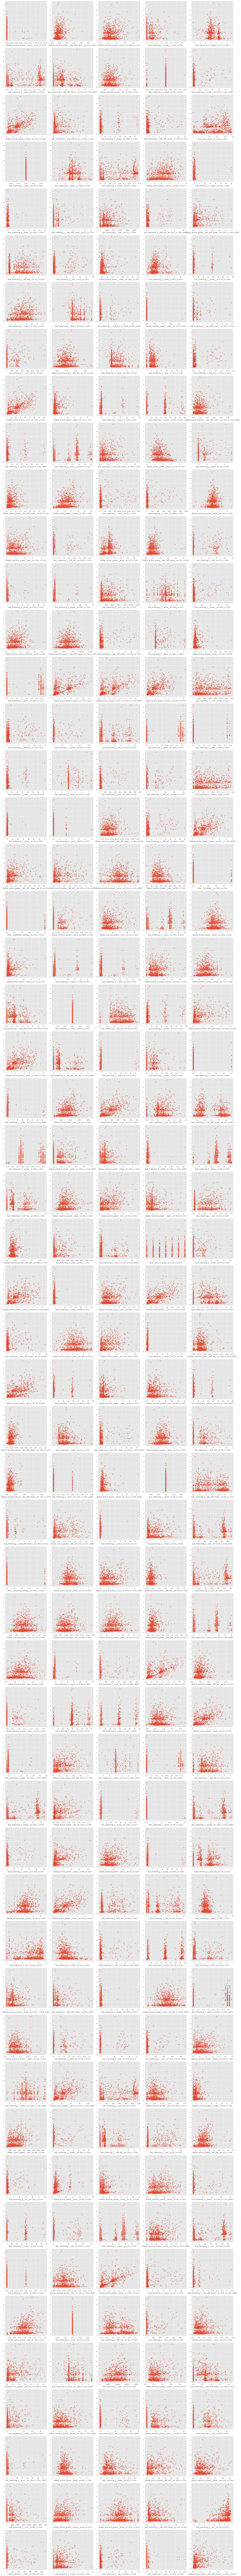

In [27]:
N = 1_000
vis_data = df_train.iloc[np.random.randint(0, len(df_train), N)]

scatter_features(vis_data[selected_cols], vis_data[y_train.name])

### Feature selection

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

# selects the K highst-scoring features based on the f_regression score
bestfeatures = SelectKBest(f_regression, k=100)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", MinMaxScaler()),
    ]
)
x = pipe.fit_transform(df_train[selected_cols])
fit = bestfeatures.fit(x,df_train[y_train.name])

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(selected_cols)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Col','Score']  #naming the dataframe columns

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning:

invalid value encountered in true_divide



`TODO`: use variable explorer

In [29]:
feats_to_retain = featureScores.nlargest(50,'Score')['Col'].str.rstrip('_shift1')
fc.reduce(feats_to_retain)

Global_active_power: (
	win: 30m   , stride: 15m: [
		FeatureDescriptor - func: FuncWrapper([robust]__amin, ['amin'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__diff_std, ['diff_std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__abs_diff_mean, ['abs_diff_mean'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__sum, ['sum'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__mean, ['mean'], {}),
	]
	win: 6h    , stride: 15m: [
		FeatureDescriptor - func: FuncWrapper([robust]__slope, ['slope'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__diff_std, ['diff_std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__sum, ['sum'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__mean, ['mean'], {}),
	]
	win: 1h    , stride: 15m: [
		

In [30]:
test_feats = construct_feats(X_test)

100%|██████████| 230/230 [00:56<00:00,  4.10it/s]


## 4.4 Demo: Learning curves

In [96]:
# define time-based cross validation
from sklearn.model_selection import TimeSeriesSplit

stride_min = 15
gap_days = 3
tscv = TimeSeriesSplit(n_splits=5, gap=int((60 / stride_min) * 24 * gap_days))

from sklearn.model_selection import KFold
# tscv = KFold(n_splits=3, shuffle=True)

In [97]:
# again, score the features 
bestfeatures = SelectKBest(f_regression, k=250)

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", MinMaxScaler()),
    ]
)
x = pipe.fit_transform(df_train[selected_cols])
fit = bestfeatures.fit(x,df_train[y_train.name])

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(selected_cols)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Col','Score']  #naming the dataframe columns

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning:

invalid value encountered in true_divide



In [98]:
# define the selected cols 
selected_cols__ = featureScores.nlargest(15,'Score')['Col'].values
selected_cols__

array(['Global_active_power__mean__w=15m_s=15m',
       'Global_active_power__sum__w=15m_s=15m',
       'Global_active_power__amin__w=15m_s=15m',
       'Global_active_power__sum__w=30m_s=15m',
       'Global_active_power__mean__w=30m_s=15m',
       'Global_active_power__amax__w=15m_s=15m',
       'Global_active_power__mean__w=1h_s=15m',
       'Global_active_power__sum__w=1h_s=15m',
       'Global_active_power__amin__w=30m_s=15m',
       'Global_active_power__amax__w=30m_s=15m',
       'Global_active_power__amax__w=1h_s=15m',
       'Global_active_power__sum__w=15m_s=15m_shift1',
       'Global_active_power__mean__w=15m_s=15m_shift1',
       'Global_active_power__amin__w=15m_s=15m_shift1',
       'Global_active_power__amin__w=1h_s=15m'], dtype=object)

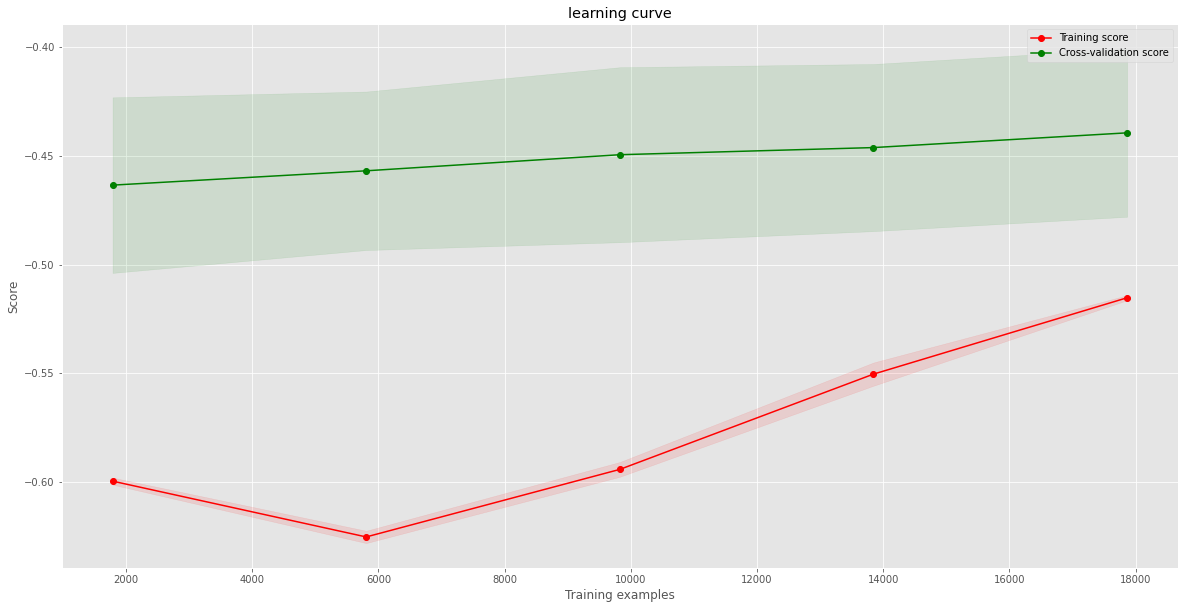

In [106]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, SGDRegressor
from sklearn.pipeline import Pipeline

pipe = Pipeline([('scaler', StandardScaler()), ('reg', SGDRegressor())])
plot_learning_curve(
    pipe, "learning curve", df_train[selected_cols__], df_train[y_train.name], cv=tscv,
    scoring='neg_mean_squared_error', n_jobs=1,
)

In [107]:
pipe.fit(df_train[selected_cols__], df_train[y_train.name])

test_predictions = pd.Series(
    pipe.predict(test_feats[selected_cols__]), index=test_feats.index
).rename("predictions").to_frame().join(y_test).dropna()

print_regression_metrics(test_predictions.iloc[:, 0], test_predictions.iloc[:, 1], "TEST")

MSE  [TEST]:  0.335
MAE  [TEST]:  0.383
MAPE [TEST]:  0.425
R2   [TEST]:  0.026


In [109]:
fig = FigureResampler(go.Figure(), default_downsampler=LTTB(interleave_gaps=True))

fig.add_trace(go.Scattergl(name="target"), hf_x=y_test.index, hf_y=y_test)

test_predictions = pd.Series(
    pipe.predict(test_feats[selected_cols__]), index=test_feats.index
).rename("predictions")

fig.add_trace(
    go.Scattergl(name=f"predictions - {len(selected_cols__)} features"),
    hf_x=test_predictions.index,
    hf_y=test_predictions,
)

df_pc_test = df_power_consumption[test_predictions.index[0]:]
fig.add_trace(
    go.Scattergl(name="GAP no shift", visible='legendonly'), 
    hf_x=df_pc_test.index,
    hf_y=df_pc_test['Global_active_power'].rolling(avg_window_min, center=True).mean()
)

fig.update_layout(title="Power consumption predictions", title_x=0.5, height=500)
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")
fig.show_dash(mode="external")

/home/jonas/git/gIDLaB/tsflex/venv/lib/python3.8/site-packages/jupyter_dash/jupyter_app.py:139: UserWarning:

The 'environ['werkzeug.server.shutdown']' function is deprecated and will be removed in Werkzeug 2.1.



Dash app running on http://127.0.0.1:8050/


## 4.5 Catboost-regression - investigating different metrics

The image below gives an overview of the most common regression losses:<br>
![overview losses](https://miro.medium.com/max/640/1*eH-5v54TH2Lmo1hWrjQNjA.jpeg)

In [110]:
# https://catboost.ai/en/docs/concepts/loss-functions-regression 
# Note: should be evaluated by using CV and then select the one which suits your purpose
# the best (or stack the predictions of the models)
mape_pipe = catboost.CatBoostRegressor(verbose=250, loss_function="MAPE")
mape_pipe.fit(df_train[selected_cols], df_train[y_train.name])
print("-" * 100)
rmse_pipe = catboost.CatBoostRegressor(verbose=250, loss_function="RMSE")
rmse_pipe.fit(df_train[selected_cols], df_train[y_train.name])
print("-" * 100)
mae_pipe = catboost.CatBoostRegressor(verbose=250, loss_function="MAE")
mae_pipe.fit(df_train[selected_cols], df_train[y_train.name])

0:	learn: 0.4136187	total: 112ms	remaining: 1m 51s
250:	learn: 0.1992754	total: 14.3s	remaining: 42.7s
500:	learn: 0.1911430	total: 30.2s	remaining: 30.1s
750:	learn: 0.1865034	total: 46.4s	remaining: 15.4s
999:	learn: 0.1833756	total: 1m 1s	remaining: 0us
----------------------------------------------------------------------------------------------------
Learning rate set to 0.085908
0:	learn: 0.9775264	total: 48.6ms	remaining: 48.6s
250:	learn: 0.5417012	total: 15.3s	remaining: 45.6s
500:	learn: 0.5147328	total: 31.9s	remaining: 31.7s
750:	learn: 0.4944099	total: 49.5s	remaining: 16.4s
999:	learn: 0.4779714	total: 1m 4s	remaining: 0us
----------------------------------------------------------------------------------------------------
0:	learn: 0.7636697	total: 55.9ms	remaining: 55.8s
250:	learn: 0.3356689	total: 16.8s	remaining: 50.2s
500:	learn: 0.3194617	total: 31.9s	remaining: 31.8s
750:	learn: 0.3110032	total: 46.9s	remaining: 15.6s
999:	learn: 0.3056341	total: 1m 2s	remaining: 0

In [111]:
for name, pipe in [("MAPE", mape_pipe), ("RMSE", rmse_pipe), ("MAE", mae_pipe)]:
    train_predictions = pd.Series(
        pipe.predict(df_train[selected_cols]), index=df_train.index, name="predictions"
    )
    df_preds = train_predictions.to_frame().join(y_train).dropna(how="any")
    print_regression_metrics(
        df_preds[target_col], df_preds.predictions, f"TRAIN-{name}"
    )
    print("-" * 30)

MSE  [TRAIN-MAPE]:  0.366
MAE  [TRAIN-MAPE]:  0.316
MAPE [TRAIN-MAPE]:  0.294
R2   [TRAIN-MAPE]:  0.651
------------------------------
MSE  [TRAIN-RMSE]:  0.228
MAE  [TRAIN-RMSE]:  0.296
MAPE [TRAIN-RMSE]:  0.393
R2   [TRAIN-RMSE]:  0.782
------------------------------
MSE  [TRAIN-MAE]:  0.338
MAE  [TRAIN-MAE]:  0.306
MAPE [TRAIN-MAE]:  0.297
R2   [TRAIN-MAE]:  0.678
------------------------------


In [112]:
for name, pipe in [("MAPE", mape_pipe), ("RMSE", rmse_pipe), ("MAE", mae_pipe)]:
    test_predictions = pd.Series(
        pipe.predict(test_feats), index=test_feats.index
    ).rename("predictions")
    df_test_preds = test_predictions.to_frame().join(y_test).dropna(how="any")
    print_regression_metrics(
        df_test_preds[target_col], df_test_preds.predictions, f"TEST-{name}"
    )
    print("-" * 30)

MSE  [TEST-MAPE]:  0.266
MAE  [TEST-MAPE]:  0.28
MAPE [TEST-MAPE]:  0.299
R2   [TEST-MAPE]:  0.614
------------------------------
MSE  [TEST-RMSE]:  0.232
MAE  [TEST-RMSE]:  0.308
MAPE [TEST-RMSE]:  0.429
R2   [TEST-RMSE]:  0.663
------------------------------
MSE  [TEST-MAE]:  0.252
MAE  [TEST-MAE]:  0.276
MAPE [TEST-MAE]:  0.306
R2   [TEST-MAE]:  0.634
------------------------------


### Visualization of the differently trained predictors

In [114]:
fig = FigureResampler(go.Figure(), default_downsampler=LTTB(interleave_gaps=True))

fig.add_trace(go.Scattergl(name="target"), hf_x=y_test.index, hf_y=y_test)


for name, pipe in [("MAPE", mape_pipe), ("RMSE", rmse_pipe), ("MAE", mae_pipe)]:
    test_predictions = pd.Series(
        pipe.predict(test_feats), index=test_feats.index
    ).rename("predictions")

    fig.add_trace(
        go.Scattergl(name=f"predictions-{name}"),
        hf_x=test_predictions.index,
        hf_y=test_predictions,
    )

df_pc_test = df_power_consumption[test_predictions.index[0]:]
fig.add_trace(
    go.Scattergl(name="GAP no shift", visible='legendonly'), 
    hf_x=df_pc_test.index,
    hf_y=df_pc_test['Global_active_power'].rolling(avg_window_min, center=True).mean()
)

fig.update_layout(title="Power consumption predictions", title_x=0.5, height=600)
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")
fig.show_dash(mode="external")

Dash app running on http://127.0.0.1:8050/


## 4.6 Shap

https://github.com/slundberg/shap

In [ ]:
plt.figure()
explainer = shap.TreeExplainer(pipe)
shap_values = explainer.shap_values(df_train[selected_cols])
shap.summary_plot(
    shap_values,
    df_train[selected_cols],
    max_display=50,
    auto_size_plot=True,
    show=False,
    color_bar=True,
)
plt.show()

In [ ]:
vals = np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(
    list(zip(selected_cols, vals)), columns=["col_name", "feature_importance_vals"]
)
feature_importance = feature_importance.sort_values(
    by=["feature_importance_vals"], ascending=False
).reset_index(drop=True)
feature_importance.head()

---

## 4.6 Uncertainty

For specific use-cases it is beneficial to add estimates of uncertainty to the prediction of your model. 

There are multiple ways of adding uncertainty to the output, depending whether the problem is a clasification or a regression problem. For a classification problem, the uncertainty estimates could be percentages assigned to each class, while for regression problems the uncertainty is either in the form of a distribution or a prediction interval. In our case, we will focus on a `regression prediction interval`.

Uncertainty is a broad term, however, two different kinds of uncertainty can be differentiated: The **epistemic** or model uncertainty and the **aleotoric** or data uncertainty.<br>
The aleotoric uncertainty is fully determined by the data and any uncertainty introduced by the current dataset. An example of the aleotoric uncertainty is a measurement error of a specific feature, e.g. the power consumption in our case. This measurement error cannot be reduced by any amount of data and is always present, hence, the aleotoric uncertainty is sometimes referred to as the irreducible uncertainty. Therefore, in any machine learning problem, the **theoretical maximum performance a model** can achieve is **bounded by** the **aleotoric uncertainty**.<br>
The epistemic uncertainty on the other hand is reducible as it contains all uncertainty introduced by your model. There are multiple sources for the epistemic uncertainty but they are all traced back by the used and trained model: the used parameters, the model assumptions, the model error, etc. In uncertainty quantification the main goal is to quantify both uncertainties. 

In regression problems, a common way of introducing uncertainty is by creating `prediction intervals`. These intervals **specify a range that will contain the true ground truth value with a certain coverage percentage**. For example, if the prediction interval for a specific output is \[8,20\] with 95% coverage then this means that the true value lies in between 8 and 20 with 95% certainty. In other words, this means that in 95 cases of 100 predictions, the ground truth value will lie in between these two values. This therefore provides uncertainty in your prediction in the form of error bars. An extension of prediction intervals uses distributions, which directly provides prediction intervals for any possible coverage percentage. However, we will limit the scope to prediction intervals in this introductory section. 

There are multiple ways to predict prediction intervals, but the most easy way makes use of `quantile regression`. In regular regression you want to directly predict the label or output, while in quantile prediction you want to predict the quantile of the labels. A quantile is a threshold or value in a distribution of samples where a percentage **p** of all values are below or equal to that threshold-value. The median of any distribution is also equal to the 0.5 or 50% quantile, as 50% of all values are equal or lower to the median. The image below explains quantiles using a normal distribution.

![image.png](https://cdn.discordapp.com/attachments/894288331309989978/920039657713053696/Image_Pasted_at_2021-12-13_20-00.jpeg)

Therefore, if you have a quantile regressor that predict the 0.975 quantile it predicts a value for each data sample, such that for all predicted values the the label is below or equal to that value in 97,5% of the cases, i.e. having a coverage of 97,5%. This technique is useful for creating a prediction interval as a prediction interval also provides a coverage, but compared to a quantile, the prediction interval has an upper and a lower bound. Therefore, we will use two models: one for the lower and one for the upper bound of the prediction interval. If we want a symmetric prediction interval of 95% we need to have a lower bound of 2.5% and an upper bound of 97.5% (as 97.5% - 2.5% = 95%).

In the following code, two CatBoostRegressors are trained but using a quantile-loss function (or pinball-loss function) where the coverage is defined by alpha.

In [ ]:
pipe = catboost.CatBoostRegressor(verbose=250, loss_function="RMSE")
pipe_upper = catboost.CatBoostRegressor(
    verbose=250, loss_function="Quantile:alpha=0.975"
)
pipe_lower = catboost.CatBoostRegressor(
    verbose=250, loss_function="Quantile:alpha=0.025"
)

# as this is a lot of data, this might take a couple of minutes
pipe.fit(df_train[selected_cols], df_train[y_train.name])
pipe_upper.fit(df_train[selected_cols], df_train[y_train.name])
pipe_lower.fit(df_train[selected_cols], df_train[y_train.name])

Evaluating a quantile model or a prediction interval cannot be done with standard metrics such as RMSE or R², as we do not have the true quantile labels. Therefore we will look back at the definition of a prediction interval: A prediction interval provides a range that will contain the true value in C % of the times, with C the coverage percentage. As a result, **to measure the performance of the prediction interval we can count how many times the label $y$ is in between the upper $y_U$ and lower bound $y_L$**. This is called the `Prediction Interval Coverage Percentage or PICP`:

$PICP(y,y_L,y_U)=\frac{1}{N} \sum_{i=1}^N  I(y_i \in [y_{L_i};y_{U_i}])$

With I the indicator function, giving a 1 if the expression is true and 0 otherwise. 

The PICP is then a measure of coverage and is an important metric in regression uncertainty quantification. However, solemnly relying on the PICP is not a good idea. Consider the case where we have perfect coverage but the model outputs the same exact value for any data sample. This is possible by providing a prediction interval that is large enough to contain all values in the dataset. Although the coverage is perfect the prediction interval is actually useless as this interval is way too large and provides no real uncertainty estimate. Therefore, it is also necessary to **measure the width of the prediction interval in conjunction with the coverage** to have full understanding of the uncertainty quantification performance of your model. This can be done using the `(Normalized) Mean Prediction Interval Width or (N)MPIW` that calculates the **mean width of all prediction intervals**:

$MPIW(y_L,y_U)=\frac{1}{N} \sum_{i=1}^N y_{U_i} - y_{U_i} $

$NMPIW(y_L,y_U)=\frac{MPIW(y_L,y_U)}{max(y)-min(y)} $

The `goal` of all uncertainty quantification models is to **achieve prediction intervals that are as small as possible but have a perfect coverage**. However, this is a trade-off. In general, to achieve a higher coverage you have to widen the prediction intervals and therefore this is called the coverage-width trade-off. 

These three metrics are defined below:

In [ ]:
def PICP(y_true, y_lower, y_upper):
    # ratio of how many times the label y is between the upper and the lower bound
    return (
        np.logical_and(y_lower <= y_true, y_true <= y_upper).sum() / len(y_true) * 100
    )


def MPIW(y_lower, y_upper):
    # 
    return np.mean(y_upper - y_lower)


def NMPIW(y_true, y_lower, y_upper):
    return MPIW(y_lower, y_upper) / (np.max(y_true) - np.min(y_true))

Since we now have defined the metrics we can apply them to the predictions of our model:

In [ ]:
train_predictions_upper = pipe_upper.predict(df_train[selected_cols])
train_predictions_lower = pipe_lower.predict(df_train[selected_cols])

nan_mask = df_train[target_col].notna()
y_true, y_pred_upper, y_pred_lower = (
    df_train[target_col][nan_mask],
    train_predictions_upper[nan_mask],
    train_predictions_lower[nan_mask],
)

print(
    "[TRAIN] PICP = "
    + str(np.round(PICP(y_true.values, y_pred_lower, y_pred_upper), 2))
    + " % -- NMPIW = "
    + str(np.round(NMPIW(y_true.values, y_pred_lower, y_pred_upper), 2))
    + " -- MPIW = "
    + str(np.round(MPIW(y_pred_lower, y_pred_upper), 2))
    + " kW"
)

As you can see, the training performance has a perfect coverage as we achieved a PICP of 95% which was our specified uncertainty requirement. The average width is 2 kW of all prediction intervals which corresponds to 24% of the range of the labels. However, it is also necessary to do this evaluation on the test set to understand how well our uncertainty model can generalize:

In [ ]:
test_feats["predictions_upper"] = pipe_upper.predict(test_feats[selected_cols])
test_feats["predictions_lower"] = pipe_lower.predict(test_feats[selected_cols])

test_feats_ = test_feats.join(y_test)
nan_mask = test_feats_[target_col].notna()
y_true, y_pred_upper, y_pred_lower = (
    test_feats_[nan_mask][target_col],
    test_feats_[nan_mask]["predictions_upper"],
    test_feats_[nan_mask]["predictions_lower"],
)

print(
    "[TEST] PICP = "
    + str(np.round(PICP(y_true.values, y_pred_lower.values, y_pred_upper.values), 2))
    + " % -- NMPIW = "
    + str(np.round(NMPIW(y_true.values, y_pred_lower.values, y_pred_upper.values), 2))
    + " -- MPIW = "
    + str(np.round(MPIW(y_pred_lower.values, y_pred_upper.values), 2))
    + " kW"
)

The coverage is a bit higher, but it is better to have a higher coverage then specified compared to a lower coverage to avoid missing crucial data. Compared to the training set, the width is slightly smaller in absolute values. In order to understand the prediction interval more, we can plot the width to the most important feature: 'Global_intensity__amin__w=15m_s=15m'. This way we can see what kind of relationship there is and how the width varies across the data. If the width is the same for any feature, then we have a homoscedastic solution, i.e. the error bars are approximately the same for every data sample. In the other case, with a varying width, we have a heteroscedastic solution. The heteroscedastic solution is often preferred as this provides more individualized prediction for the data sample instead of a more general solution. 

In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(
    df_train["Global_active_power__amin__w=15m_s=15m"],
    train_predictions_upper - train_predictions_lower,
)
plt.xlabel("Global_intensity__amin__w=15m_s=15m")
plt.ylabel("Width prediction interval (kW)")

In the figure above, we can see that the width increases on average with the global intensity. Therefore, we can conclude that we have a heteroscedastic solution which can be used in practice together with good PICP and NMPIW metrics for the test set. 

### Visualizing confidence interval

In [ ]:
fig = FigureResampler(
    make_subplots(rows=2, shared_xaxes=True, specs=[[{}], [{"secondary_y": True}]]),
    default_n_shown_samples=1000,
    default_downsampler=LTTB(interleave_gaps=True),
)

test_predictions = pd.Series(
    pipe.predict(test_feats[selected_cols]), index=test_feats.index
).rename("predictions")


fig.add_trace(go.Scattergl(name="target"), hf_x=y_test.index, hf_y=y_test, row=1, col=1)

df_pc_test = df_power_consumption[y_test.index[0]: y_test.index[-1]]
fig.add_trace(
    go.Scattergl(name="REAL - GAP", visible="legendonly"),
    hf_x=df_pc_test.index,
    hf_y=df_pc_test["Global_active_power"],
    row=1,
    col=1,
)

fig.add_trace(
    go.Scattergl(name="predictions", marker_color="red"),
    hf_x=test_predictions.index,
    hf_y=test_predictions,
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=test_feats.index,
        y=test_feats.predictions_upper,
        name="upper_bound",
        showlegend=False,
        marker_color="black",
        line=dict(width=0),
        mode="lines",
    ),
    downsampler=EveryNthPoint(),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=test_feats.index,
        y=test_feats.predictions_lower,
        name="lower bound",
        showlegend=False,
        marker_color="black",
        line=dict(width=0),
        mode="lines",
        fillcolor="rgba(255, 0, 0, 0.2)",
        fill="tonexty",
    ),
    downsampler=EveryNthPoint(),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scattergl(name="MAE"),
    row=2,
    col=1,
    hf_x=test_predictions.index,
    hf_y=abs(test_predictions - test_predictions.to_frame().join(y_test).iloc[:, -1]),
)

fig.update_layout(title="Power consumption predictions", title_x=0.5, height=700)
fig.update_xaxes(title="Time")
fig.update_yaxes(title="AVG power consumption (kW)")
fig.show_dash(mode="external")

---

# 5. Serialization

In [ ]:
def pickle_dump(obj, file_name):
    with open(file_name, "wb") as f:
        pickle.dump(obj, f)

In [ ]:
# serialize the feature extraction logic
fc.serialize("fc.pkl")
sp.serialize("sp.pkl")

# serialize the pipeline
pickle_dump(selected_cols, "cols.pkl")
pickle_dump(pipe, "pipe.pkl")

---

# 6. Some notes

This notebook is far from complete and serves as "quick" first iteration

Ideally one would tackle this approach using the [cookiecutter-data science](https://drivendata.github.io/cookiecutter-data-science/) structure (see demo)


Some steps which I would further pursue:
* Compute some more advanced signal features (peaks) / shapelets
* using a linear model as baseline
* trying other windows / strides
* as you keep getting new data (client want to use it for forecasting); incremental learning models might be a better suit for this use-case